In [1]:
import pandas as pd
import numpy as np


In [2]:
data = pd.read_csv('/Users/ilya/Desktop/GitHub_Repositories/My_knowledge_base/Курс Start ML/Финальный проект/DataSets/data_10_percent.csv')

## Обрезаем дата сет
def sample_5_percent(group):
    frac = 0.5
    return group.sample(frac=frac)

data = data.groupby('post_id', group_keys=False).apply(sample_5_percent)

In [5]:
data

,timestamp,user_id,post_id,target,age,text_len,views,likes,like_percentage,business,covid,entertainment,movie,politics,sport,tech,average_likes
0,1640284174,32443,1,1,23,1967,8508,1067,0.013002,7.0,15.0,9.0,23.0,6.0,8.0,2.0,1216.625181
1,1639391859,126763,1,0,23,1967,8508,1067,0.013002,8.0,9.0,6.0,26.0,6.0,5.0,3.0,1216.625181
2,1637745842,167041,1,0,19,1967,8508,1067,0.013002,0.0,6.0,0.0,3.0,1.0,2.0,0.0,1216.625181
3,1640818118,136559,1,1,44,1967,8508,1067,0.013002,5.0,13.0,2.0,15.0,2.0,2.0,4.0,1216.625181
4,1638216776,96796,1,1,35,1967,8508,1067,0.013002,9.0,12.0,1.0,16.0,5.0,10.0,2.0,1216.625181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7689258,1634924812,54315,7319,0,32,790,6585,720,0.008774,1.0,10.0,2.0,17.0,0.0,1.0,1.0,1376.696927
7689259,1634829064,168335,7319,0,22,790,6585,720,0.008774,1.0,14.0,0.0,22.0,9.0,16.0,4.0,1376.696927
7689260,1638884551,72107,7319,1,22,790,6585,720,0.008774,6.0,19.0,3.0,25.0,9.0,10.0,3.0,1376.696927
7689261,1633466993,161396,7319,0,37,790,6585,720,0.008774,3.0,19.0,0.0,36.0,2.0,6.0,3.0,1376.696927


In [24]:
X = data.drop('target', axis=1) # input features (make sure to drop the target column) 
y = data['target']	#	target	variable


In [25]:
'''Devision for train and test data'''

user_ids = data['user_id'].unique()

# shuffle user ids
np.random.shuffle(user_ids)

# split user ids into train and test
train_user_ids = user_ids[:int(len(user_ids) * 0.8)]

# split data into train and test
train_df = data[data['user_id'].isin(train_user_ids)]
test_df = data[~data['user_id'].isin(train_user_ids)]

# Make sure 'user_id' and 'post_id' are set as index before creating 'X' and 'y'
train_df.set_index(['user_id', 'post_id'], inplace=True)
test_df.set_index(['user_id', 'post_id'], inplace=True)

# split train and test into X and y
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']

X_test = test_df.drop('target', axis=1)
y_test = test_df['target']

In [26]:
from catboost import CatBoostClassifier

# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=300,  # Modify this parameter as needed
    depth=10,  # Modify this parameter as needed
    learning_rate=0.1,  # Modify this parameter as needed 
    eval_metric='PRAUC',  # Changed to PR AUC
    verbose=100,  # Output the training process every 200 iterations
    random_seed=42
)

# Fit model
model.fit(X_train, y_train, eval_set=(X_test, y_test))


0:	learn: 0.1640578	test: 0.1624590	best: 0.1624590 (0)	total: 588ms	remaining: 2m 55s
100:	learn: 0.1854543	test: 0.1825877	best: 0.1825877 (100)	total: 1m 39s	remaining: 3m 15s
200:	learn: 0.1917514	test: 0.1867824	best: 0.1867824 (200)	total: 3m 21s	remaining: 1m 39s
299:	learn: 0.1961045	test: 0.1884134	best: 0.1884134 (299)	total: 5m 1s	remaining: 0us

bestTest = 0.1884133551
bestIteration = 299



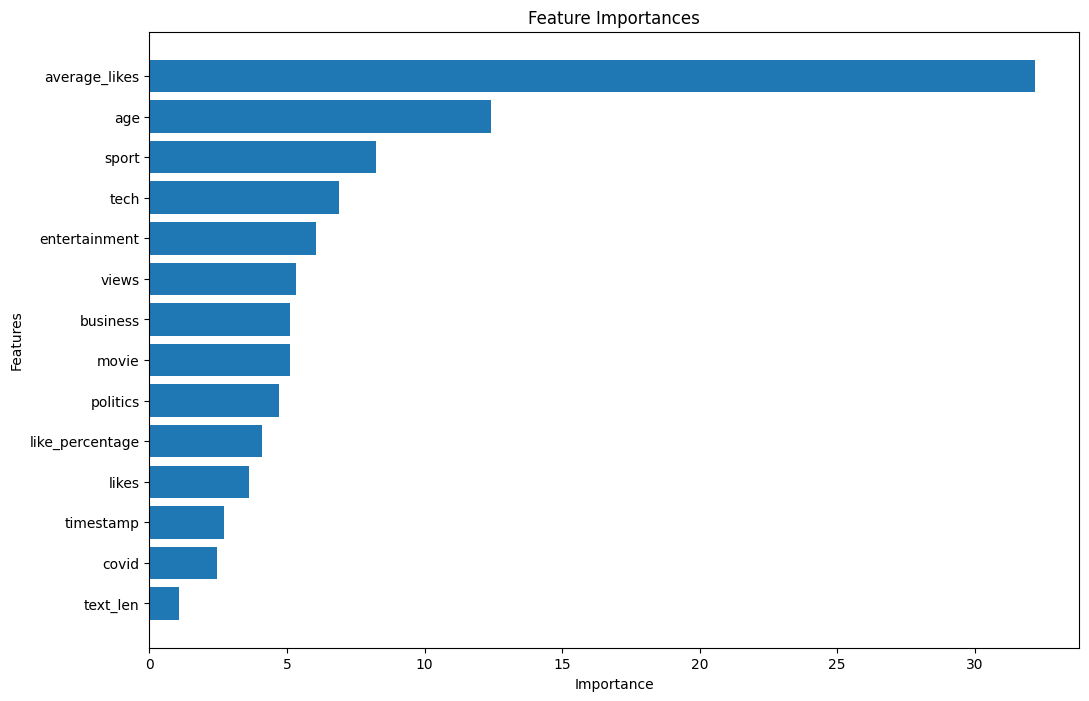

In [27]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = model.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [28]:
def hitrate5(model, X, Y):
    check = pd.concat([Y,
                       pd.Series(model.predict_proba(X)[:,1], index=Y.index, name='probas')],
                      axis=1)
    check = check.reset_index().drop(columns='post_id')
    
    pred_list = [check[check.user_id == user_id].sort_values('probas', ascending=False).iloc[:5]
                 for user_id in check.user_id.unique()]

    return pd.concat(pred_list).groupby('user_id').target.sum().map(lambda x: min(1, x)).mean()

# x, y - это выборка из test пользователей с их feed_data
print('Hitrate@5: {:.4f}'.format(hitrate5(model, X_test, y_test)))

Hitrate@5: 0.6451


In [13]:
# Save model
model.save_model('catboost_model_data10_best_hitrate.cbm', format='cbm')

In [ ]:
from_file = CatBoostClassifier()
from_file.load_model('/Users/ilya/Desktop/GitHub_Repositories/My_knowledge_base/Курс Start ML/Финальный проект/DataSets/catboost_model_data10_best_hitrate.cbm', format='cbm')
from_file.get_params()
from_file.predict_proba(X_test)

## Checking coleration between features

In [21]:
numerical_columns =  list(data.select_dtypes(exclude='object').columns)

### Секретные функции для фильтрации признаков
def get_redundant_pairs(data):
    pairs_to_drop = set()
    cols = data.columns
    for i in range(0, data.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(filter_data, n=5):
    au_corr = filter_data.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(filter_data)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(data[numerical_columns], 10))

Top Absolute Correlations
views     likes            0.949330
covid     movie            0.811799
politics  sport            0.709821
business  entertainment    0.663320
covid     politics         0.621699
views     average_likes    0.608222
movie     politics         0.603535
covid     sport            0.597638
movie     sport            0.578891
covid     tech             0.559556
dtype: float64
